# <center>Rigid Body Replica Exchange

<h1> General Functions

In [5]:
# Imports
import os, sys, glob
import numpy as np

import ls_parsetxt
import ls_parsepdb

In [3]:
s = "blablabla # comment"
print(s.split("#")[0])

blablabla 


In [6]:
def removeEndComment(S):
    """
    Removes everything after # sign from a string
    """
    return S.split("#")[0]
#    if len(S) > 1:
#        .split("#")[0]
#        i = -1
#        for c in S:
#            i += 1
#            if c == "#":
#                break
#            
#        return S[0 : i+1]
#    else:
#        return S

# Generate Input

In [7]:
# Keyword categories
# IO / Run / Thermodynamics / Worlds / Software
class RobosampleInput:
    """
    Hold info in Robosample input file
    """
    
    def __init__(self, molDirs, outDir, writePdbFreq):
        """
        Sets IO parameters
        """
        # IO
        self.molDirs = molDirs
        self.nofMolecules = len(self.molDirs)
        self.outDir = outDir
        self.writePdbFreq = writePdbFreq
        
        # Worlds
        self.nofWorlds = 0
        self.flexFNs = [[None]]
        self.roots = [[None]]
        self.rootMobs = [[None]]
        self.sprs = [None] # samples per round
        
        # Sampling
        self.sampler = None
        self.tss = [None]
        self.mdsteps = [None]
        
        # Thermodynamics
        self.T = [None] # Temperature
        self.bT = [None] # Boost temperature
        self.ffscale = [None] # Force field scale (AMBER = 1)
        self.gbsa = [None] # GBSA scale
        self.fp = [None] # use Fixman potential
        self.ft= [None] # use Fixman torque
        
        # Replica exchange
        self.rexFN = None
        
        # Geometry
        self.geometry = False
        self.distances = [[0, 1]]
        self.dihedrals = [[0, 1, 2, 3]]
    #
    
    def defineWorlds(self, flexFNs, roots, rootMobs, samples_per_round):
        """
        param flexFNs: List of lists of flexibility files (worlds x mols)
        param roots: List of lists of roots
        param rootMobs: List of lists of root mobilities
        param samples_per_round: samples per round
        """
        self.sprs = samples_per_round
        self.nofWorlds = len(self.sprs)
        print(self.nofWorlds, flexFNs, len(flexFNs))
        assert(len(flexFNs) == self.nofMolecules)
        #for molFlexes in flexFNs:
        #    assert(len(molFlexes) == self.nofWorlds)
        assert(len(roots) == self.nofMolecules)
        assert(len(rootMobs) == self.nofMolecules)
        
        
        self.flexFNs = flexFNs
        self.roots = roots
        self.rootMobs = rootMobs
    #
    
    def defineSampling(self, sampler, tss, mdsteps):
        """
        Will use on sampler for all the worlds
        param sampler: sampler name (VV or HMC)
        param tss float: list of integration timesteps for samplers
        param mdsteps: # of integration steps
        """
        self.sampler = sampler
        self.tss = tss
        self.mdsteps = mdsteps
    #
    
    def defineThermodynamics(self, T, bT, ffscale, gbsa, fp, ft):
        self.T = T # Temperature
        self.bT = bT # Boost temperature
        self.ffscale = ffscale # Force field scale (AMBER = 1)
        self.gbsa = gbsa # GBSA scale
        self.fp = fp # use Fixman potential
        self.ft = ft # use Fixman torque
    #

    def defineREX(self, rexFile):
        self.rexFN = rexFile
    #

    def defineGeometry(self, distances, dihedrals):
        """
        distances: list of of 2 atom indexes lists
        dihedrals: list of of 4 atom indexes lists
        """
        self.geometry = True
        self.distances = distances
        self.dihedrals = dihedrals
    #
    
    def dump(self):
        print("IO (mol outDir pdbFreq): ", self.molDirs, self.outDir, self.writePdbFreq)
        print("Worlds flex, roots, samples: \n", self.flexFNs, self.roots, self.rootMobs, self.sprs)
        print("Sampling: ", self.sampler, self.tss, self.mdsteps)
        print("Thermodynamics: T, boostT, ffscale, GBSA, FP, FT", 
              self.T, self.bT, self.ffscale, self.gbsa, self.fp, self.ft)
    #
    
    def generateInput(self, seed, nofRounds):        
            # Params specific to this input
            runStr = "# Run\n"
            runStr += ("SEED " + str(seed) + \
                "\nROUNDS "  + str(nofRounds) + "\n" + \
                """REPRODUCIBLE FALSE
OPENMM TRUE
OPENMM_CalcOnlyNonbonded TRUE
""")
            runStr += "\n"

            # IO
            IOStr = "# IO\n"
            IOStr += "MOLECULES "
            for i in range(self.nofMolecules):
                IOStr += self.molDirs[i]
                
            IOStr += """
PRMTOP ligand.prmtop
INPCRD ligand.rst7
OUTPUT_DIR """ + self.outDir
                
            # Replica exchange
            if self.rexFN != None:
                rexStr = "\n\n# Replica exchange\n"
                rexStr += """RUN_TYPE REX
REX_SWAP_EVERY 1\n"""
                rexStr += ("REX_FILE " + self.rexFN)
            else:
                rexStr = "\n\nRUN_TYPE Normal"
                
            # Worlds flexibilities
            flexStr = "\n\n# Flexibility\n"
            flexStr += "RBFILE "
            for i in range(self.nofWorlds):
                for j in range(self.nofMolecules):
                    flexStr += "ligand.rb "
            flexStr += "\nFLEXFILE "
            for i in range(self.nofMolecules):
                for j in range(self.nofWorlds):
                    flexStr += (self.flexFNs[i][j] + " ")
            flexStr += "\nROOTS "
            for i in range(self.nofMolecules):
                for j in range(self.nofWorlds):
                    flexStr += (str(self.roots[i][j]) + " ")
            flexStr += "\nROOT_MOBILITY "
            for i in range(self.nofMolecules):
                for j in range(self.nofWorlds):
                    flexStr += (self.rootMobs[i][j] + " ")
            flexStr += "\n\n"        
            
            # Worlds
            worldsStr = "# Worlds\nRANDOM_WORLD_ORDER FALSE\n"
            worldsStr += "WORLDS "
            for i in range(self.nofWorlds): worldsStr += (" R" + str(i)) # Only 9 worlds
            worldsStr += "\nTHREADS"
            for i in range(self.nofWorlds): worldsStr += " 0"
            worldsStr += "\nNONBONDED_METHOD"
            for i in range(self.nofWorlds): worldsStr += " 0"
            worldsStr += "\nNONBONDED_CUTOFF"
            for i in range(self.nofWorlds): worldsStr += " 1.2"
            worldsStr += "\nVISUAL "
            for i in range(self.nofWorlds): worldsStr += " FALSE"
            worldsStr += "\nPRINT_FREQ "
            for i in range(self.nofWorlds): worldsStr += " 1"
            worldsStr += "\nROUNDS_TILL_REBLOCK "
            for i in range(self.nofWorlds): worldsStr += " 1"
            worldsStr += "\nSAMPLES_PER_ROUND "
            for i in range(self.nofWorlds): worldsStr += (" " + str(self.sprs[i]))
            worldsStr += "\nWRITEPDBS " + str(self.writePdbFreq)
            for i in range(self.nofWorlds - 1): worldsStr += " 0"
            worldsStr += "\n\n"

            # Geometry
            geomStr = "\nGEOMETRY "
            if self.geometry:
                for i in range(self.nofWorlds): geomStr += " TRUE"
            else:
                for i in range(self.nofWorlds): geomStr += " FALSE"
            geomStr += "\nDISTANCE "        
            for i in range(len(self.distances)):
                for j in range(len(self.distances[i])):
                    geomStr += (" " + str(self.distances[i][j]))
            geomStr += "\nDIHEDRAL "        
            for i in range(len(self.dihedrals)):
                for j in range(len(self.dihedrals[i])):
                    geomStr += (" " + str(self.dihedrals[i][j]))
                


            # Sampling
            samStr = "\n\n# Sampling\n"
            samStr += "SAMPLER "
            for i in range(self.nofWorlds): samStr += (" " + self.sampler)
            samStr += "\nTIMESTEPS "
            for i in range(self.nofWorlds): samStr += (" " + str(self.tss[i]))
            samStr += "\nMDSTEPS "
            for i in range(self.nofWorlds): samStr += (" " + str(self.mdsteps[i]))
            samStr += "\nBOOST_MDSTEPS "
            for i in range(self.nofWorlds): samStr += " 1"
            samStr += "\nNMA_OPTION "
            for i in range(self.nofWorlds): samStr += " 0"

            # Thermodynamics
            thermoStr = "\n\n# Thermodynamics\nTHERMOSTAT "
            for i in range(self.nofWorlds): thermoStr += " Andersen"            
            thermoStr += "\nTEMPERATURE_INI "
            for i in range(self.nofWorlds): thermoStr += (" " + str(self.T[i]))
            thermoStr += "\nTEMPERATURE_FIN "
            for i in range(self.nofWorlds): thermoStr += (" " + str(self.T[i]))
            thermoStr += "\nBOOST_TEMPERATURE "
            for i in range(self.nofWorlds): thermoStr += (" " + str(self.bT[i]))
            thermoStr += "\nFFSCALE "
            for i in range(self.nofWorlds): thermoStr += (" " + str(self.ffscale[i]))
            thermoStr += "\nGBSA "
            for i in range(self.nofWorlds): thermoStr += (" " + str(self.gbsa[i]))
            thermoStr += "\nFIXMAN_POTENTIAL "
            for i in range(self.nofWorlds): thermoStr += (" " + str(self.fp[i]))
            thermoStr += "\nFIXMAN_TORQUE "
            for i in range(self.nofWorlds): thermoStr += (" " + str(self.ft[i]))


                
            return runStr + IOStr + rexStr + flexStr + worldsStr + geomStr + samStr + thermoStr
        
        

    

In [8]:
# Replica exchange protocol
class REXProtocol:
    """
    Replica exchange protocol
    
    Given N worlds defined and K replicas, we need a 
    K x Nmax table of worlds per replica, where Nmax is 
    maximum nof worlds in a replica.
    
    Equivalent tables of timesteps, MD steps and samples per rounds
    are needed
    """
    
    def __init__(self, tss, mdsteps, sprs):
        """
        Init
        """
        self.nofReplicas = 0
        assert(len(tss) == len(mdsteps) == len(sprs))
        self.rexTss = tss
        self.rexMdsteps = mdsteps
        self.rexSprs = sprs
    #
    
    def geomTs(self, Ti, Tf, nofWantedReplicas):
        """
        Generates a geometric distribution of Ts
        """
        self.nofReplicas = nofWantedReplicas
        self.Ts = [Ti]
        r = (Tf / Ti)**(1 / (nofWantedReplicas - 1))
        for i in range(1, nofWantedReplicas):
            self.Ts.append(self.Ts[i-1] * r)                
        return self.Ts
    #
    
    def generateTrexContent(self, rexWorlds):
        """
        Write trex file
        param rexWorlds: list of worlds lists for each replica
        """
        assert(self.nofReplicas == len(rexWorlds))
        self.rexWorlds = rexWorlds
        rexStr = "NOF_REPLICAS " + str(self.nofReplicas) + "\n#Title\n"
        for i in range(self.nofReplicas):
            rexStr += (str(i) + " TEMPERATURE " + str((self.Ts[i]))) + "\n"
            rexStr += str(i) + " WORLD_INDEXES"
            for j in range(len(self.rexWorlds[i])):
                rexStr += " " + str(self.rexWorlds[i][j])
            rexStr += "\n" + str(i) + " TIMESTEPS"
            for j in range(len(self.rexWorlds[i])):
                rexStr += " " + str(self.rexTss[i][j])
            rexStr += "\n" + str(i) + " MDSTEPS"
            for j in range(len(self.rexWorlds[i])):
                rexStr += " " + str(self.rexMdsteps[i][j])
            rexStr += "\n" + str(i) + " SAMPLES_PER_ROUND"
            for j in range(len(self.rexWorlds[i])):
                rexStr += " " + str(self.rexSprs[i][j])                
            rexStr += "\n#\n"            
            
        return rexStr
    #

In [9]:
# IO
molDirs = ["ala1"]
outDir = "temp"
writePdbFreq = 0

# Types of simulation
IC = 0; TD = 1; RM = 2
regimens = np.array([IC, TD, RM], dtype = int)
regimenNames = ["ic", "td", "rm"]
allFlexFNs = ["ligand.flex.cart", "ligand.flex.7td", "ligand.flex.2td"]
allTrexFNs = ["trex.ic.dT200.dat", "trex.td.dT200.dat", "trex.rm.dT200.dat"]

# Fixed number of worlds per replica 
nofWorldsPerReplica = 2

# Sampling
sampler ="HMC"

# REX

rexWorlds = [[0,1], [0, 2], [0, 2], [0, 2]]
rexTss = [[0.0007, 0.0007], [0.0007, 0.003], [0.007, 0.003], [0.007, 0.003]]
rexMdsteps = [[0, 300], [0, 70], [0, 70], [0, 70]]
rexSprs = [[1, 1], [1, 1], [1, 1], [1, 1]] # sampler per round

rexProtocol = REXProtocol(rexTss, rexMdsteps, rexSprs)
Ts = rexProtocol.geomTs(300, 450, 4)
#print(Ts)

trexFNs = []
for simType in regimens:
    rexWorlds = [[0,1], [0, 2], [0, 2], [0, 2]]
    REXFContent = rexProtocol.generateTrexContent(rexWorlds)
    trexFNs.append("trex." + regimenNames[simType] + ".dT200.dat")
    #print(trexFN)
    #print(REXFContent)
    #with open(trexFNs[-1], 'w') as F:
    #    F.write(REXFContent)
    
#Ts = rexProtocol.geomTs(300, 450, 10)
#ccWorlds = [0,1,2]
#ccRexWorlds = [ccWorlds for i in range(10)]
#print(ccRexWorlds)
#REXFContent = rexProtocol.generateTrexContent(ccRexWorlds)
#ccTrexFNs = []
#ccTrexFNs.append("trex.cc." + regimenNames[simType] + ".dat")
#with open(ccTrexFNs[-1], 'w') as F:
#    F.write(REXFContent)

<h2> Generate inputs </h2>

In [10]:
# Common things

# Worlds
roots = [[0, 0, 0]]
rootMobs = [["Weld", "Weld", "Weld"]]

# Sampling
sampler ="HMC"
tss = [0.001, 0.001, 0.001]
mdsteps = [10, 10, 10]
sprs = [1, 1, 1] # sampler per round

# Thermodynamics
T = [300.0, 300.0, 300.0]
bT = [300.0, 300.0, 300.0]
ffscale = ["AMBER", "AMBER", "AMBER"]
gbsa = [0.0, 0.0, 0.0]
fp = ["FALSE", "TRUE", "TRUE"]
ft = ["FALSE", "TRUE", "TRUE"]

# Geometry
distances = [[1, 18]]
dihedrals = [[4, 6, 8, 14], [6, 8, 14, 16]]

dT = int(200.0)

# REX things

# Worlds
nofRounds = 10000

for simType in regimens:
    trexFN = trexFNs[simType]
    flexFNs = [[allFlexFNs[0], allFlexFNs[0], allFlexFNs[simType]]]

    roboInput = RobosampleInput(molDirs, outDir, writePdbFreq)
    roboInput.defineREX(trexFN)
    roboInput.defineWorlds(flexFNs, roots, rootMobs, sprs)
    roboInput.defineSampling(sampler, tss, mdsteps)
    roboInput.defineThermodynamics(T, bT, ffscale, gbsa, fp, ft)
    roboInput.defineGeometry(distances, dihedrals)
    #roboInput.dump()

    seeds = np.array(range(10), dtype = int)
    seeds += (1000 * (simType+1))
    print(seeds)

    batchStr = ""
    for seed in seeds:        
        specStr = regimenNames[simType] + ".dT" + str(dT) + "." + str(seed)
        inFN = "inp."
        outFN = "out."
        inFN += specStr
        outFN += specStr

        #print(batchStr)
        #print(FN)
        FContent = roboInput.generateInput(seed, nofRounds)
        #print(FContent)
        #with open(inFN, 'w') as F:
        #    F.write(FContent)

        
        batchStr += "nohup /home/laurentiu/git4/Robosample/build/release/robosample/src/GMOLMODEL_robo "
        batchStr += inFN
        batchStr += (" > " + outFN + " 2>&1 &\n")
        
    batchFN = "batch." + regimenNames[simType] + ".bash"
    print(batchFN)
    
    #with open(batchFN, "w") as batchF:
    #    batchF.write(batchStr)


3 [['ligand.flex.cart', 'ligand.flex.cart', 'ligand.flex.cart']] 1
[1000 1001 1002 1003 1004 1005 1006 1007 1008 1009]
batch.ic.bash
3 [['ligand.flex.cart', 'ligand.flex.cart', 'ligand.flex.7td']] 1
[2000 2001 2002 2003 2004 2005 2006 2007 2008 2009]
batch.td.bash
3 [['ligand.flex.cart', 'ligand.flex.cart', 'ligand.flex.2td']] 1
[3000 3001 3002 3003 3004 3005 3006 3007 3008 3009]
batch.rm.bash


# Analyze Output

In [11]:
!ls

ala1		   inp.td.dT200.2001	   out.rm.dT200.3005
batch.ic.bash	   inp.td.dT200.2002	   out.rm.dT200.3006
batch.rm.bash	   inp.td.dT200.2003	   out.rm.dT200.3007
batch.td.bash	   inp.td.dT200.2004	   out.rm.dT200.3008
inp.ic.dT200.1000  inp.td.dT200.2005	   out.rm.dT200.3009
inp.ic.dT200.1001  inp.td.dT200.2006	   out.td.dT200.2000
inp.ic.dT200.1002  inp.td.dT200.2007	   out.td.dT200.2001
inp.ic.dT200.1003  inp.td.dT200.2008	   out.td.dT200.2002
inp.ic.dT200.1004  inp.td.dT200.2009	   out.td.dT200.2003
inp.ic.dT200.1005  line.td.dT200.2001.raw  out.td.dT200.2004
inp.ic.dT200.1006  out.ic.dT200.1000	   out.td.dT200.2005
inp.ic.dT200.1007  out.ic.dT200.1001	   out.td.dT200.2006
inp.ic.dT200.1008  out.ic.dT200.1002	   out.td.dT200.2007
inp.ic.dT200.1009  out.ic.dT200.1003	   out.td.dT200.2008
inp.rm.dT200.3000  out.ic.dT200.1004	   out.td.dT200.2009
inp.rm.dT200.3001  out.ic.dT200.1005	   rexz.ipynb
inp.rm.dT200.3002  out.ic.dT200.1006	   temp
inp.rm.dT200.3003  out.ic.dT200.1007	   temp.pn

In [12]:
FNList = glob.glob("out.*")
#print(FNList)

nofWorlds = 0
with open("inp.ic.dT200.1000", "r") as F:
    all_lines = F.readlines()
    linei = -1
    for line in all_lines:
        linei += 1
        line = removeEndComment(line)
        if(len(line) > 1):
            words = line.split()
            if words[0][0] != "#":
                if words[0] == "WORLDS":
                    nofWorlds = len(words) - 1


print("nofWorlds", nofWorlds)   

nofWorlds = 2

nofWorlds 3


In [14]:
#
nofReplicas = 0
Ts = np.zeros((1))
worlds = np.zeros((1, nofWorldsPerReplica))
tss = np.zeros((1, nofWorldsPerReplica))
mdsteps = np.zeros((1, nofWorldsPerReplica))
spr = np.zeros((1, nofWorldsPerReplica))

with open("trex.ic.dT200.dat", "r") as F:
    all_lines = F.readlines()
    linei = -1
    for line in all_lines:
        linei += 1
        words = line.split()
        if words[0][0] != "#":
            if words[0] == "NOF_REPLICAS":
                nofReplicas = int(words[1])
                print("nofReplicas", nofReplicas)
                Ts.resize((nofReplicas))
                worlds.resize((nofReplicas, nofWorldsPerReplica)) # HARDCODED !!!!
                tss.resize((nofReplicas, nofWorldsPerReplica)) # HARDCODED !!!!
                mdsteps.resize((nofReplicas, nofWorldsPerReplica)) # HARDCODED !!!!
                spr.resize((nofReplicas, nofWorldsPerReplica)) # HARDCODED !!!!
            else:
                if not nofReplicas:
                    "NOF_REPLICAS not set first in grex file."
                    break
                else:
                    K = int(words[0])
                    if words[1] == "TEMPERATURE":
                        Ts[K] = float(words[2])
                        
                    elif words[1] == "WORLD_INDEXES":
                        for wi in range(nofWorldsPerReplica): # HARDCODED !!!
                            worlds[K, wi] = words[2+wi]

                    elif words[1] == "TIMESTEPS":
                        for wi in range(nofWorldsPerReplica): # HARDCODED !!!
                            tss[K, wi] = words[2+wi]
                            
                    elif words[1] == "MDSTEPS":
                        for wi in range(nofWorldsPerReplica): # HARDCODED !!!
                            mdsteps[K, wi] = words[2+wi]
                            
                    elif words[1] == "SAMPLES_PER_ROUND":
                        for wi in range(nofWorldsPerReplica): # HARDCODED !!!
                            spr[K, wi] = words[2+wi]                        
                                        
print("Ts", Ts)
print("worlds", worlds)
print("tss", tss)
print("mdsteps", mdsteps)
print("spr", spr)



nofReplicas 4
Ts [300.         343.41427277 393.11120913 450.        ]
worlds [[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
tss [[0.0007 0.0007]
 [0.0007 0.0007]
 [0.0007 0.0007]
 [0.0007 0.0007]]
mdsteps [[300. 300.]
 [300. 300.]
 [300. 300.]
 [300. 300.]]
spr [[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]


In [15]:
# Get output
def getOutputData(outFN):
    """
    Read data from an Robosample output file
    """
    batchi = -1
    outD = np.zeros((nofRounds, nofReplicas, nofWorldsPerReplica, 8)) * np.nan
    with open(outFN, "r") as F:
        all_lines = F.readlines()
        linei = -1
        for line in all_lines:
            linei += 1
            line.replace(" ", "").replace(",", "",100)
            words = line.split()
            if  (words[0] == "REX") and (words[1] == "batch"):
                batchi += 1
                replicai = -1
            elif (words[0] == "REX") and (words[1] == "replica"):
                replicai += 1
                worldi = -1            
            elif (words[0] == "Temperature") and (words[1] == "set") and (words[2] == "to"):
                for j in range(nofWorldsPerReplica):
                    outD[batchi][replicai][j][0] = float(words[3])                
            elif (words[0] == "World") and (words[2] == "NU"):
                worldi += 1
            elif(words[0] == "pe_o"):
                pe_o = float(words[1].replace(",", ""))
                pe_n = float(words[3].replace(",", ""))
                outD[batchi][replicai][worldi][1] = pe_o
                outD[batchi][replicai][worldi][2] = pe_n

            elif(words[0] == "ke_prop"):
                ke_prop = float(words[1].replace(",", ""))
                ke_n = float(words[3].replace(",", ""))
                outD[batchi][replicai][worldi][3] = ke_prop
                outD[batchi][replicai][worldi][4] = ke_n

            elif(words[0] == "fix_o"):
                fix_o = float(words[1].replace(",", ""))
                fix_n = float(words[3].replace(",", ""))
                outD[batchi][replicai][worldi][5] = fix_o
                outD[batchi][replicai][worldi][6] = fix_n

            elif (len(words) > 2) and (words[2] == "(metropolis-hastings)"):
                if words[1] == "accepted":
                    acc = 1.0
                else:
                    acc = 0.0
                outD[batchi][replicai][worldi][7] = acc
            
            #if linei > 500:
            #    print(outD)
            #    break
            
        return outD
#

outFN = "out.ic.dT200.1000"

outD = getOutputData(outFN)

print(outD[0:3])
      

[[[[300.         -55.79422    -14.65719     88.42353     47.61116
      0.           0.           1.        ]
   [300.         -14.65719    -25.60682     89.17269    100.15019
    217.38611    217.38611      1.        ]]

  [[343.41427277 -25.60682     -9.60435     98.90341     83.08599
      0.           0.           1.        ]
   [343.41427277  -9.60435      7.41398     96.35818     79.40595
    246.75185    246.75185      1.        ]]

  [[393.11120913   7.41398     25.04914    100.10404     82.57828
      0.           0.           1.        ]
   [393.11120913  25.04914     14.34073    111.32561    122.21896
    283.89329    283.89329      1.        ]]

  [[450.          14.34073      8.52431    101.60504    107.52642
      0.           0.           1.        ]
   [450.           8.52431      8.90045    141.87615    140.93587
    323.84177    323.84177      1.        ]]]


 [[[343.41427277 -25.60682    -32.47722     71.85108     78.63656
      0.           0.           1.        ]


<h2>Extract Thermodynamic States</h2>

In [16]:
Ix_T = 0
Ix_pe_o = 1
Ix_pe_n = 2
Ix_ke_prop = 3
Ix_ke_n = 4
Ix_fix_o = 5
Ix_fix_n = 6
Ix_acc = 7

#k = 0
#print(outD[:,k,0,Ix_T])

thermoStateD = np.zeros((nofRounds, nofReplicas, nofWorldsPerReplica, 8)) * np.nan
mix = np.zeros((nofRounds, nofReplicas)) * np.nan

thermoIx = 0
thermoT = Ts[0]
batchi = -1
for D in outD:
    batchi += 1
    replicai = -1
    for replica in D:
        #print(replica)
        replicai += 1
        for tix in range(Ts.size):
            if (replica[0, 0] - Ts[tix]) < 0.000001:
                thermoStateD[batchi, tix] = replica
                mix[batchi, tix] = replicai
                break
                
print(mix)

[[0. 1. 2. 3.]
 [1. 0. 3. 2.]
 [0. 1. 2. 3.]
 ...
 [1. 0. 2. 3.]
 [0. 1. 2. 3.]
 [1. 2. 3. 0.]]


<h2> Kinetic Energy

[ 89.17269  80.94217  63.34393 ...  83.68807 109.11161  53.88345]
[96.35818 76.90802 84.19707 ... 89.19382 64.53624 62.30059]
[111.32561 110.69606  98.17276 ... 106.74979 102.94449  79.65407]
[141.87615 105.80798 132.00324 ... 125.76666 116.08196 124.21764]


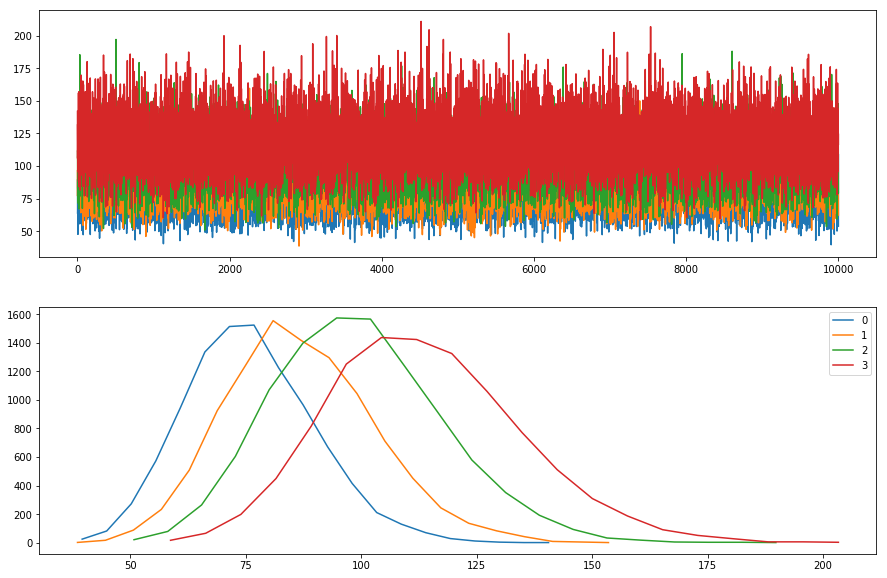

In [18]:
import matplotlib
import matplotlib.pyplot as plt

# Kinetic energy
KHists = []
ke_prop = [None] * nofReplicas
for k in range(nofReplicas):
    ke_prop[k] = thermoStateD[:,k,1,Ix_ke_prop]
    print(ke_prop[k])
    ke_prop[k] = ke_prop[k][np.logical_not(np.isnan(ke_prop[k]))]
    h = np.histogram(ke_prop[k], bins = 20)
    KHists.append(h)
    
plt.rcParams['figure.figsize'] = [15, 10]
fig, axs = plt.subplots(2, 1)
for k in range(nofReplicas):
    axs[0].plot(ke_prop[k], label = "T")
    axs[1].plot(KHists[k][1][:-1], KHists[k][0], label = str(k))
plt.legend()
plt.show()


<h1>  Potential Energy

[-14.65719  -8.27195 -24.4231  ... -23.00424 -11.33109 -28.41248]
[ -9.60435 -32.47722 -19.88785 ...  -6.68151 -19.59427   8.35842]
[25.04914 12.61283 15.03066 ... 13.23276 19.34601 16.54885]
[  8.52431  26.73359  -3.38533 ...  17.45108  23.64036 -26.85247]


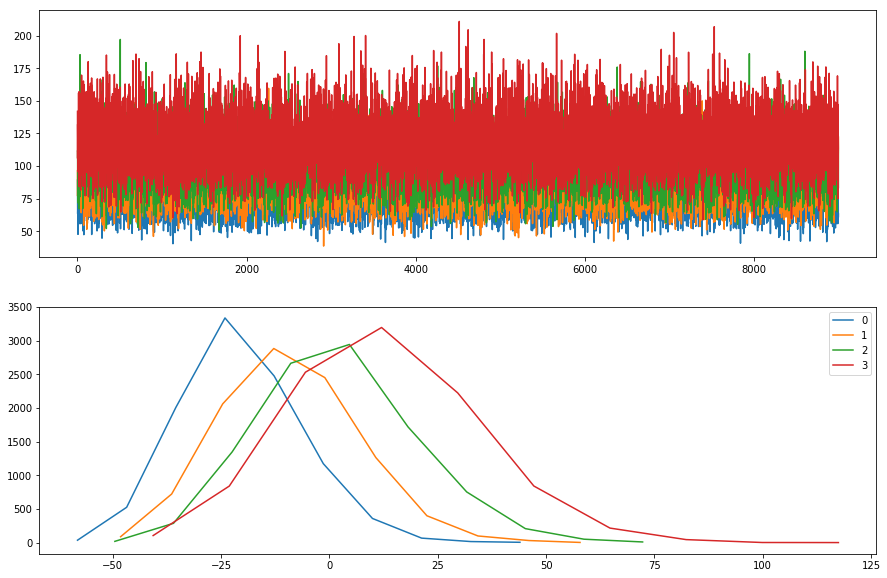

In [19]:
# Kinetic energy
UHists = []
for k in range(nofReplicas):
    pe_o_k = thermoStateD[:,k,1,Ix_pe_o]
    print(pe_o_k)
    pe_o_k = pe_o_k[np.logical_not(np.isnan(pe_o_k))]    
    h = np.histogram(pe_o_k)
    UHists.append(h)

# Plot    
fig, axs = plt.subplots(2, 1)
for k in range(nofReplicas):
    axs[0].plot(thermoStateD[:,k,1,Ix_ke_prop][0:9000], label = "T")
    axs[1].plot(UHists[k][1][:-1], UHists[k][0], label = str(k))
plt.legend()
plt.show()

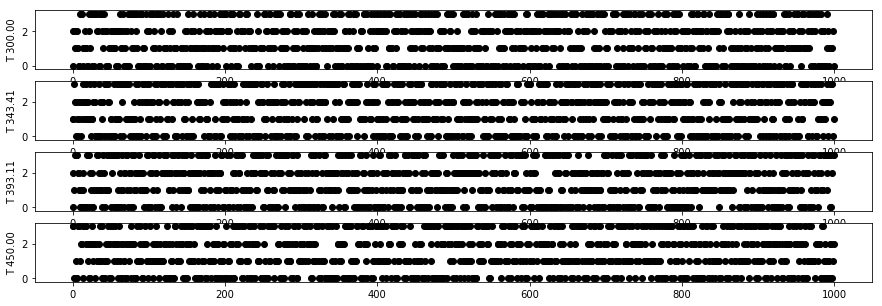

In [20]:
stride = 10
plt.rcParams['figure.figsize'] = [15, 5]
fig, axs = plt.subplots(4, 1)
for k in range(nofReplicas):
    #axs[k].plot(range(len(mix[:,k][::stride])), mix[:,k][::stride], color = 'black')
    axs[k].scatter(range(len(mix[:,k][::stride])), mix[:,k][::stride], color = 'black')
    axs[k].set_ylabel("T " + str("%.2f" % Ts[k]))
    
plt.show()

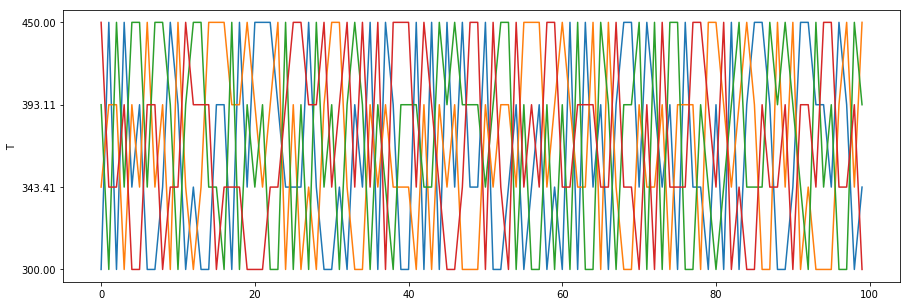

In [21]:
fig, axs = plt.subplots(1, 1)
stride = 100
for k in range(nofReplicas):
    #axs.scatter(range(len(mix[:,k][0:-1:stride])), mix[:,k][0:-1:stride])
    axs.plot(range(len(mix[:,k][0:-1:stride])), mix[:,k][0:-1:stride])
axs.set_ylabel("T")
axs.set_yticks(range(Ts.size))
axs.set_yticklabels([("%.2f" % Ts[k]) for k in range(nofReplicas)])
    
plt.show()

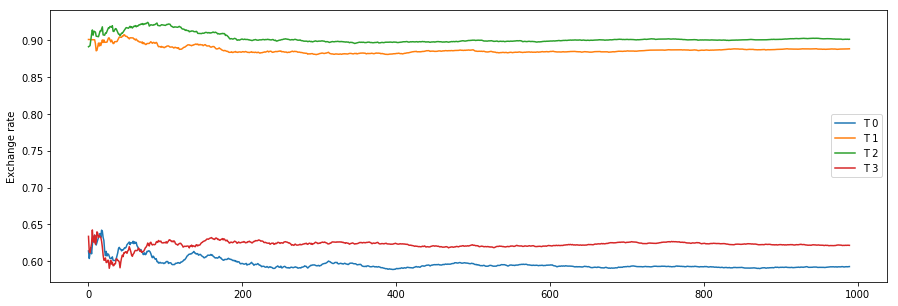

In [22]:
#print(mix.shape)     
xrate = np.zeros(mix.shape, dtype = float)
# Create v with arange ... is better
v = np.ones(xrate.shape, dtype = float)
for i in range(1, mix.shape[0]):
    for j in range(mix.shape[1]):
        v[i, j] += v[i-1, j]
        # Check if exchange happend
        if mix[i-1, j] != mix[i, j]:
            xrate[i, j] = xrate[i-1, j] + 1.0
        else:
            xrate[i, j] = xrate[i-1, j]

xrate /= v

colors = ["blue"]

fig, axs = plt.subplots(1, 1)
for k in range(nofReplicas):
    axs.plot(xrate[:,k][::10][10:], label = "T " + str(k))
    axs.set_ylabel("Exchange rate")
    
plt.legend()    
plt.show()